# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
from src.solidStuffManagement import *

In [2]:
#FLUID PARAMETERS 
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
Re = 1 # Reynolds number
#FLUID PARAMETERS
rhoF = 1000
mu = rhoF*U*e/Re #(Pa.s)
grav = np.array([0.0,-9.81])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF


In [3]:
#GEOMETRY
Lx = 2
Ly = 2
lx = 0.5
ly=1
#PARTICLES & SPACES PARAMETERS : 
dr = ly/20
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#SOLID PARAMETERS
ls = 0.4
ws = 0.2
rhoS = 500
ms = dr*dr*rhoS 
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()

In [4]:
#INIT PART:
#% COMPLETE HERE
part = addBox(part,[Lx,Ly/2],FLUID,dr,rhoF)
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF)
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF)
numberOfNonSolidParticles = len(part)
part = addBox(part,[(Lx-ws)/2, (Ly-ls), ws, ls], MOBILESOLID, dr, rhoS)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
numberOfSolidPart = len(part)-numberOfNonSolidParticles
# END

<IPython.core.display.Javascript object>


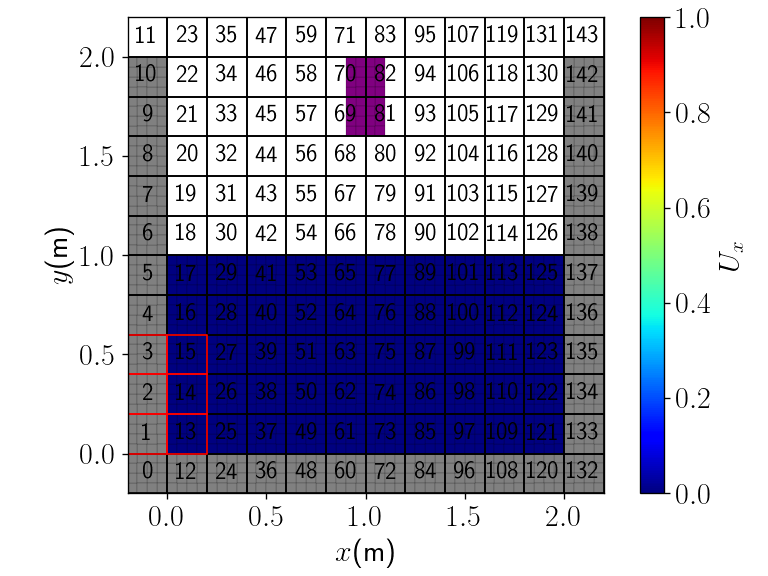

In [5]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [6]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

In [34]:
spid_145 = int(part[:,SPID][500])
listnb = listNeibSpace[spid_145,:]
listnb = listnb[listnb>-1]
listnb = listnb[listnb!=500]

        
        
print(spid_145)
print(listnb)
print(listFluidNb)


50
[384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623]
[384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 576 577 578 579 580 581 582 58

Initialisation de la pression

In [ ]:
def initWaterPressure(part):
    infoTab = part[:,INFO]
    y_i = part[infoTab == FLUID] [:,POS[1]]
    p_i = np.linalg.norm(grav)*rhoF*(Ly/2-y_i)
    rho_i = density(p_i,B,rhoF,gamma)
    part[infoTab == FLUID, RHO] = rho_i
    return part

In [ ]:
part = initWaterPressure(part)
%matplotlib notebook
Pmax= rhoF*np.linalg.norm(grav)*Ly/2
tabPres = pressure(part[:,RHO],B,rhoF,gamma)
domain = [xOrigin,xMax,yOrigin,yMax,0,Pmax]
plotPropertiesWithBound(part,tabPres,r'Pressure',domain,dr,1)

In [ ]:
OG = computeCenterOfMass(part, numberOfSolidPart)
OG